# Model the response of a charge-integrating amplifier using Laplace Transforms

We'll model the following circuit: 

<img src="img/preamp.jpg" style="width: 600px;"/>

In the frequency domain, the impedance of a resistor is given by $Z_R = R$ and the impedance of a capacitor is given by $Z_C = 1/sC$ where $s=j\omega$ is the complex frequency. In the circuit above, we have two parallel elements in feedback ($C$ and $R_2$), which we can lump together as $Z_F = Z_R || Z_C$ where:  
$$
\begin{align}
Z_F &= Z_R || Z_C = \frac{Z_R\,Z_C}{Z_C+Z_R} = \frac{(R)(1/sC)}{1/sC + R} = \frac{R}{1+sRC}
\end{align}
$$
The output voltage can then be expressed in terms of the input voltage by recognizing that the circuit topology is that of an inverting amplifier with $Z_1 = R_1$ and $Z_2$ = $Z_F$, and whatever current $I$ flows through $Z_1$ will also flow through $Z_F$, meaning that 
$$
I = \frac{V_{in}-0}{R_1} = \frac{0-V_{out}}{Z_F}
$$
So we have:
$$
\frac{V_{out}}{V_{in}} = -\frac{Z_F}{Z_1} = -\frac{1}{R_1}\frac{R}{1+sRC}
$$

The final step is to point out that the input current is given by $V_{in}/R_1$ (since the input to the op-amp is held at virtual ground). So the frequency-dependent "gain" (aka the "transfer function" $H(s)$) of the circuit can be expressed as the output voltage in terms of the input current:
$$
H(s) = \frac{V_{out}}{I_{in}} = \frac{V_{out}}{V_{in}/R_1} = -\frac{R}{1+sRC}
$$



# Specifying a transfer function in python
The `scipy.signal` module has the `lti` or "linear, time-invariant" class for which you specify the transfer function $H(s)$ and the class can calculate things like the impulse response (e.g. for a circuit that is the output voltage when the input is delta-function spike), or the output for an arbitrary input -- this is the convolution of the input signal with the impulse response.

To specify the transfer function, you can just specify the coefficients of the $s$-polynomials in the numerator and denominator of $H(s)$. For example, if you have $H(s) = (5s^2+2s+3)/(s^2-2)$, you would do:
```
from scipy import signal
sys = signal.lti([5, 2, 3], [1, 0, -2])  # (numerator, denominator)
```
In our case, we have: $H(s) = R/(RC s + 1)$, so we do:
```
Rf = 1e7    # 10 Mohm
Cf = 15e-12 # 15 pF
sys = signal.lti([Rf], [Rf*Cf, 1])
```

We know that the decay time-constant $\tau$ of the impulse response is set by the $R_F C_F$ product: $\tau = R_F C_F$, which for the Cremat CR-111, is $\tau = (10\,M\Omega)(15\,pF) = 150\mu s$. 


In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [4]:
# xfer function: -R/(1+sRC) = [0*s - R] / [RC*s + 1]
Rf = 1e7    # ohms (feedback resistor)
Cf = 15e-12 # farads (feedback cap)
sys = signal.lti([Rf], [Rf*Cf, 1])
#print(sys)

tt, yt = sys.impulse(N=1000)
ff, yf = sys.freqresp() # ff is in rad/sec; yf are complex magnitudes
ff /= (2*np.pi)  # frequency in hertz

t_tau = [150.3003003] us


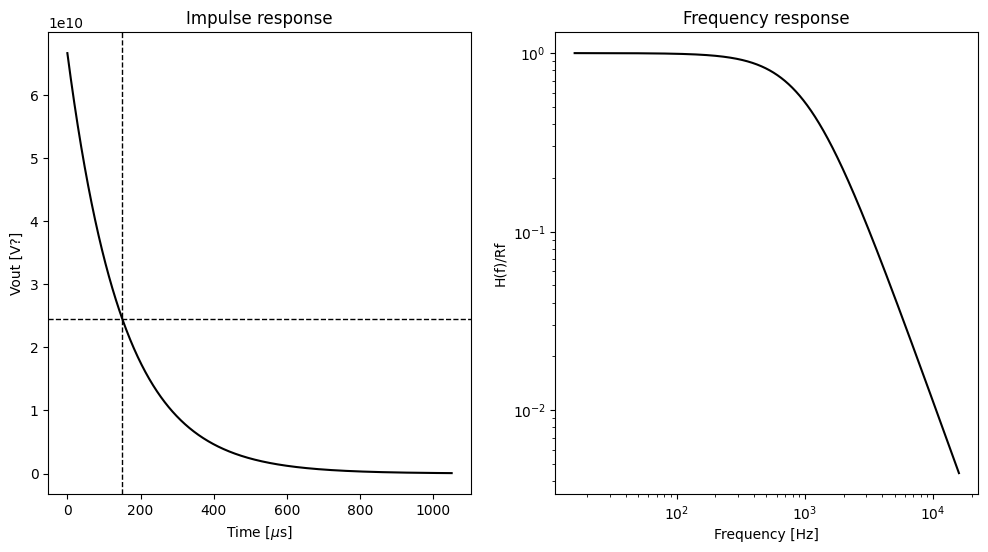

In [6]:
# Plot the impulse response and the frequency response
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axs[0].plot(tt*1e6, yt, color='k')
axs[0].set_title("Impulse response")
axs[0].set_xlabel("Time [$\mu$s]")
axs[0].set_ylabel("Vout [V?]")
#
axs[1].plot(ff, yf/Rf, color='k')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title("Frequency response")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel("H(f)/Rf")

# Find the 1/e point
v_decay = yt[0]*np.exp(-1)
axs[0].axhline(v_decay, linestyle='--', color='k', linewidth=1)
dv_min = np.abs(yt - v_decay).min()
ii = np.where(np.abs(yt-v_decay) == dv_min)[0]
axs[0].axvline(tt[ii]*1e6, linestyle='--', color='k', linewidth=1)
print(f"t_tau = {tt[ii]*1e6} us")

In [7]:
# inject 1 pC of charge via an input current Io with a top-hat shape
# such that the product of dt and Io is 1 pC
# e.g. if dt = 1 us, then 
# so Io * dt = 1pC => Io = 1pC/dt = 1pC/1e-6s = 1uA
nn = int(2e6)
tt0 = np.linspace(0, 800, num=nn) # us

# Generate top-hat input currents
II_1us = np.zeros_like(tt0)
II_1us[np.where(tt0<1)[0]] = 1e-6 # amps
II_100us = np.zeros_like(tt0)
II_100us[np.where(tt0<1e2)[0]] = 1e-8 # amps

tt0 *= 1e-6 # convert to seconds

tout, Vout_1us, _ = sys.output(II_1us, tt0)
tout, Vout_100us, _ = sys.output(II_100us, tt0)

Integrals of 1us and 100us = 9.949573904325832e-06, 9.93135095260322e-06


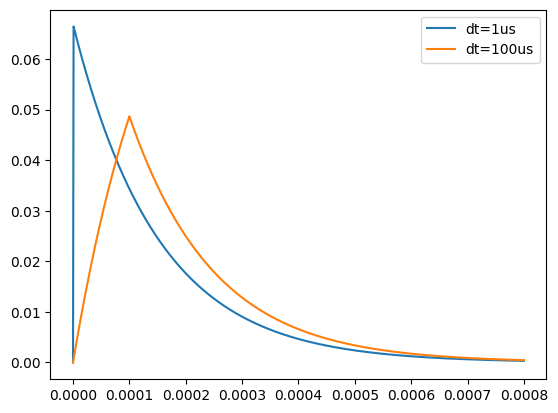

In [8]:
# Plot the resulting waveforms (Vout)
plt.plot(tout, Vout_1us, label='dt=1us')
plt.plot(tout, Vout_100us, label='dt=100us')
plt.legend()

int1 = np.trapz(Vout_1us, tout)
int100 = np.trapz(Vout_100us, tout)
print(f"Integrals of 1us and 100us = {int1}, {int100}")

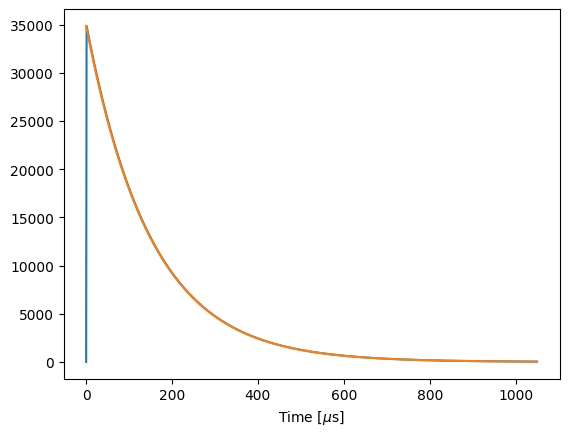

In [9]:
# Test: 
# if you input a delta function, the Vout should look like the impulse response
# May need to sort out the normalization...

II_impulse = np.zeros_like(tt)
II_impulse[0] = 1.0
tout, Vout_impulse, _ = sys.output(II_impulse, tt)
plt.plot(tout*1e6, Vout_impulse)
plt.xlabel("Time [$\mu$s]")
plt.plot(tt*1e6, yt*np.max(Vout_impulse)/np.max(yt))

# Tail pulser input
A common calibration tool for a preamplifier is a so-called "tail pulser" like the Ortec Model 480
The tail pulser is, itself, an exponential (voltage vs. time), with some decay time. The transfer function of the preamp is also an exponential. So what does the output voltage look like in this case?

The transfer function of the preamp (including the series capacitor at the test input) is:
$$
H(s) = \frac{-C_{test}R_f}{R_fC_f s + 1}
$$
where $C_{test}$ is the capacitance of the series capacitor at the test input. For the Cremat CR-150 evaluation board, $C_{test}=C_2 = 1\,\mbox{pF}$. And for the CR-110 preamp chip, we have $C_f=1.4\,\mbox{pF}$ and $R_f=100\,\mbox{M}\Omega$, so the preamp decay time constant is $\tau_f = R_f C_f = 140\,\mu\mbox{s}$.

[-8.77070030e-01  9.65568782e-05  1.56117877e-01]
tau [us] = 96.55687815159037


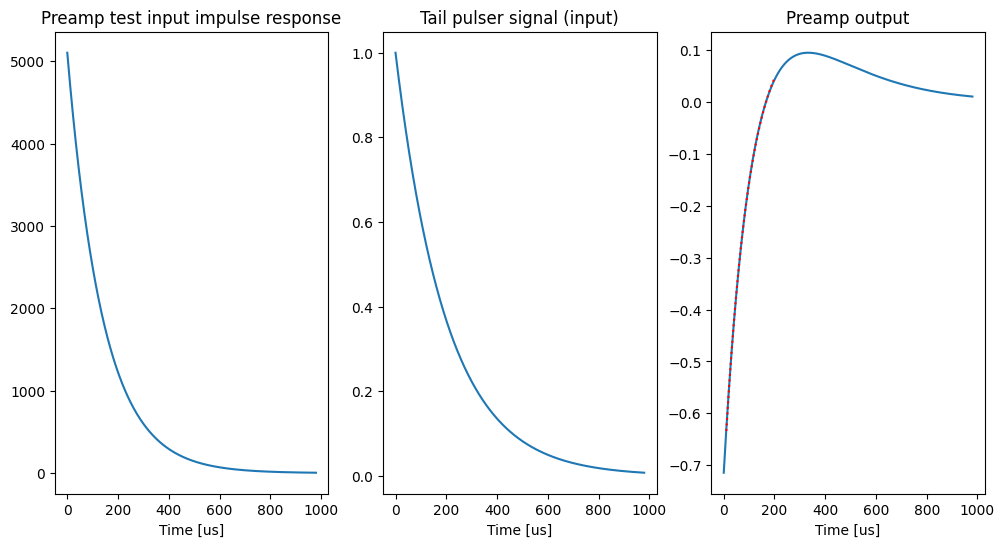

In [43]:
# xfer function: -R/(1+sRC) = [0*s - R] / [RC*s + 1]
Rf = 100e6    # ohms (feedback resistor)
Cf = 1.4e-12  # farads (feedback cap)
Ctest = 1e-12 # farads (test cap = 1pF)
sys = signal.lti([-Ctest*Rf, 0], [Rf*Cf, 1])  # transfer fxn for Vin --> Vout
#print(sys)

#tt = np.linspace(0, 2e-3, num=10000)
tt, yt = sys.impulse(N=10000)
#tt, yt = sys.impulse(T=tt)
ff, yf = sys.freqresp() # ff is in rad/sec; yf are complex magnitudes
ff /= (2*np.pi)  # frequency in hertz

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
axs[0].plot(tt*1e6, yt)
axs[0].set_xlabel("Time [us]")
axs[0].set_title("Preamp test input impulse response")

# But wait, the preamp has a capacitor in series with the test input
# So the transfer function must be adjusted accordingly
# so that we can specify a *voltage* at the test input
# and then find the output voltage of the preamp.
# OR we can assume that the input current is just proportional to the derivative of the input voltage:
# I = C_test * dVin/dt

tau_pulser = 200e-6 # seconds
#tin = np.linspace(0, 1.5e-3, num=10000) # seconds
#Vin = np.exp(-tin/tau_pulser)
Vin = np.exp(-tt/tau_pulser)
#Ctest = 1e-12 # C    (Ctest=1pF)
#dt = tin[1]-tin[0]
#dVdt = np.gradient(Vin, dt)
#Iin = Ctest * dVdt

# The tail pulser voltage is an exponential with decay timeconstant of 400us (or 200us...)
axs[1].plot(tt*1e6, Vin)
axs[1].set_xlabel("Time [us]")
axs[1].set_title("Tail pulser signal (input)")

tout, Vout, _ = sys.output(Vin, tt)
axs[2].plot(tout*1e6, Vout)
#axs[2].set_xlim(0,1200)
#axs[2].plot(tt*1e6, dVdt)

# fit an exponential to the output
from scipy.optimize import curve_fit 
def fit_func(x, a, b, c):
    return a * np.exp(-x/b) + c

tmin = 10*1e-6
tmax = 200*1e-6
idx = np.where( (tout > tmin) & (tout<tmax) )[0]
a0 = -0.8
b0 = 50e-6
c0 = 0
popt, pcov = curve_fit(fit_func, tout[idx], Vout[idx], p0=[a0,b0,c0])
print(popt)
axs[2].plot(tout[idx]*1e6, fit_func(tout[idx], *popt), 'r:', label="Fitted Curve")
axs[2].set_xlabel("Time [us]")
axs[2].set_title("Preamp output")
print(f"tau [us] = {popt[1]*1e6}")
